In [1]:
import oritelib as orite
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fasta_path = 'test_data/New_bacteria/Streptococcus_pyogenes_str_Manfredo_fasta.fasta'
genbank_path  = 'test_data/New_bacteria/Streptococcus_pyogenes_str_Manfredo_genbank.gb'


# Import fasta seq
seq = orite.seq_from_fasta(fasta_path)
print('Genome length: ',  len(seq))

Genome length:  1841271


In [3]:
# Max rotate 

max_things = orite.max_rotate_seq_and_skew_calc(seq)

max_cg = max_things[0]
max_cgc = max_things[1]
max_fasta = max_things[2]
max_offset = max_things[3]


inital max gc skew indx 52844
max cgc skew indx 850681


In [4]:
# Z - curve
xn, yn, zn = orite.calc_z_curve(max_fasta)

RY = xn
KM = yn

In [5]:
# Normalize skews 
cgc_scaled = orite.scale_skew(max_cgc)
RY_scaled = orite.scale_skew(RY)
KM_scaled = orite.scale_skew(KM)

In [6]:
# Lets try moving on with a score curve of: (CGC_SCALED - KM_SCALED)_SCALED
score_curve = orite.scale_skew(cgc_scaled - KM_scaled) 

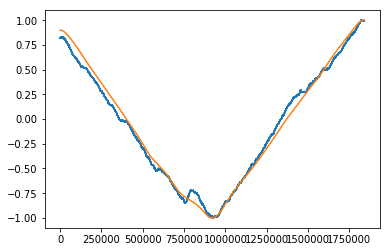

In [7]:
plt.plot(score_curve)
plt.plot(cgc_scaled)

In [8]:
# EXTRACT GENBANK INFORMATION and get all non coding regions with scores taken from the score-curve


g = orite.genbank_to_non_coding_intervals(genbank_path)

true_nc_intervals = g[0] # - List of touples
true_nc_positions = g[1] # - all NC positions in an arrays
non_coding_plus = g[2] # - nc regions interval touple list - WILL NOT BE USED
non_coding_neg  = g[3] # - nc regions interval touple list - WILL NOT BE USED


all_nc_regions = orite.get_phased_nc_region_list(true_nc_intervals, seq, max_offset, score_curve)
#print('total number of intial non coding regions: ', len(all_nc_regions))

In [9]:

# note that we take the negative of the avarage score and thus the below should be flipped
def filter_out_regions_above_score(region_list, score_thresh = -0.50):
    
    new_list = []
    
    neg_score = - score_thresh
    
    for region in region_list:
        if region.cgc_val > neg_score:
            new_list.append(region)
    
    return new_list 





# Removes row
def remove_kmer_rows_with_densisty_below_thresh(region, d_threshold):
    
    new_dict = dict()
    
    for k, rows_list in region.kmer_info.items():
        new_rows = []
        
        for row in rows_list:
            
            if row[2] > d_threshold:
                new_rows.append(row)
                
        new_dict.update({k:new_rows})

        #print({k:new_rows})
        
    
    region.kmer_info = new_dict
        
        






# WHOLE KMER FILTERING AND SORTING FUNCITON. 
# BEGINING WITH A ALL_NC_REGIONS LIST THAT HASNT HAD ITS KMERS COMPUTEDED. 
def prcoess_and_filter_all_nc_regions_list(all_nc_regions, 
                                           kmer_lengths_of_interest, 
                                           region_length_threshold=50, 
                                           occurance_threshold=3, 
                                          score_thresh = -0.75, 
                                          d_tresh = 0.01):
    
    
    print('Filtering process\nTotal number of intial non coding regions: ', len(all_nc_regions))
    
    
    # Filter based on region length threshold. Default is 50 base
    long_enough_regions = orite.filter_regions_by_length(all_nc_regions, region_length_threshold)
    print('Length filtering - number of nc regions above 50 in length: ', len(long_enough_regions))
    
    
    
    # Compute kmers info 
    x0 = orite.calc_kmers_from_region_list(long_enough_regions, kmer_lengths_of_interest)

    # Filter out kmers rows in each nc_objects kmer_info field based on occurances 
    regions_3_and_more_occ = orite.filter_region_list_by_kmer_occurence(x0, occurance_threshold)
    print('Kmer Occurence filtering - number of nc regions with kmers  having 3 or more occurances: ', len(regions_3_and_more_occ))

    
    # Compute densities for each kmer row of each nc_region
    regions_3_and_more_occ_with_density = orite.calc_density_for_region_list(regions_3_and_more_occ)

    # Remove regions containing overlapping repeats 
    regions_without_overlapping_repaets = orite.remove_overlapping_kmers_from_region_list(regions_3_and_more_occ_with_density)

    
    # Some regions might have only contained kmer rows with overlapping regions. 
    # Therefore we need to remove once more empty kmers. 

    x1 = orite.filter_empty_kmer_regions(regions_without_overlapping_repaets)
    
    #removes kets (kmer lengths with empty values )
    x2 = orite.filter_out_empty_kmer_key_in_region_list(x1)
    print('Overlapp filtering - number of nc regions without overlapping repeats: ', len(x2))

    # Keep only regions were 
    x3 = filter_out_regions_above_score(x2, score_thresh)
    
    print('Number of regions with scores "below" ', score_thresh ,': ', len(x3))
    
        
    x4 = orite.sort_region_list_on_density(x3)
    
    # This changes the list and doesnt return anything 
    orite.sort_regions_by_score(x4)
    
    
    ## 
    for region in x4:
        remove_kmer_rows_with_densisty_below_thresh(region, d_tresh)
        
    
    
    x5 = orite.filter_empty_kmer_regions(x4)
    
    #removes kets (kmer lengths with empty values )
    x6 = orite.filter_out_empty_kmer_key_in_region_list(x5)
    print('Number of regions with kmer_densities above ',d_tresh,' - ',   len(x6))

    
    
    print('\n---Done---')
    return x6


Filtering process
Total number of intial non coding regions:  1376
Length filtering - number of nc regions above 50 in length:  996
Kmer Occurence filtering - number of nc regions with kmers  having 3 or more occurances:  737
Overlapp filtering - number of nc regions without overlapping repeats:  537
Number of regions with scores "below"  -0.75 :  89
Number of regions with kmer_densities above  0.01  -  88

---Done---


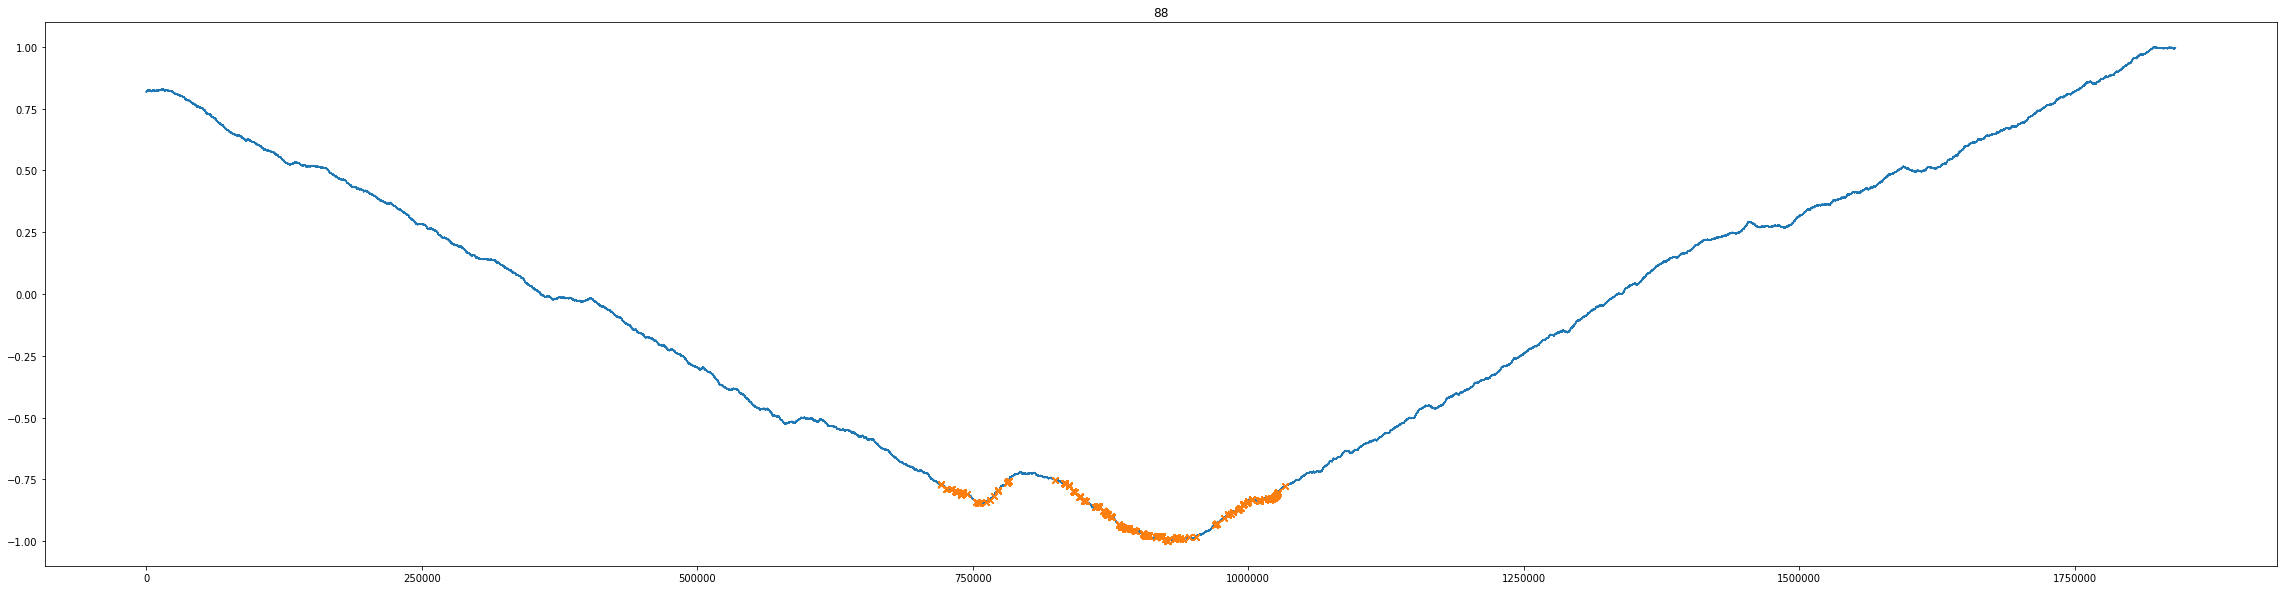

In [10]:
x = prcoess_and_filter_all_nc_regions_list(all_nc_regions, [4, 5, 6,7,8,9], occurance_threshold=5)

orite.plot_region_list(curve=score_curve, region_list=x, rotated=True)

In [17]:
orite.print_region_list_kmer_info(x)

region: 0 ---  score:  0.9993821993998896 ---- pos:  1830676 ---- max_relative_start_pos 927151
	k= 4
	 ATTT  -  [7, 209, 280, 286, 300, 328, 362, 385]  -  density: 0.03977272727272727
	 TCAA  -  [6, 90, 109, 127, 136, 191, 315]  -  density: 0.02666666666666667
	 GAAA  -  [5, 141, 173, 262, 297, 335]  -  density: 0.02577319587628866
	 TGAA  -  [5, 140, 172, 261, 296, 334]  -  density: 0.02577319587628866
	 TTTC  -  [5, 2, 184, 189, 210, 218]  -  density: 0.023148148148148147
	 ATGA  -  [5, 139, 260, 295, 341, 374]  -  density: 0.02127659574468085
	 TTTA  -  [6, 105, 281, 287, 302, 363, 388]  -  density: 0.02120141342756184
	 TTCT  -  [6, 3, 133, 219, 275, 291, 309]  -  density: 0.0196078431372549
	 AGAT  -  [5, 117, 284, 326, 369, 406]  -  density: 0.01730103806228374
	 TCTC  -  [6, 4, 16, 125, 134, 249, 353]  -  density: 0.017191977077363897
	 ACCA  -  [5, 84, 236, 240, 323, 392]  -  density: 0.016233766233766232
	 AAAG  -  [6, 32, 142, 174, 264, 401, 412]  -  density: 0.0157894736842

	 AATG  -  [9, 183, 230, 236, 266, 277, 327, 607, 641, 740]  -  density: 0.01615798922800718
	 TGAT  -  [11, 35, 185, 192, 205, 279, 356, 574, 582, 645, 693, 720]  -  density: 0.016058394160583942
	 ATGT  -  [8, 231, 237, 267, 298, 328, 642, 722, 741]  -  density: 0.01568627450980392
	 ATGA  -  [9, 138, 184, 278, 502, 573, 581, 608, 692, 719]  -  density: 0.01549053356282272
	 AAGT  -  [9, 17, 288, 369, 399, 407, 436, 562, 566, 603]  -  density: 0.015358361774744027
	 TTAC  -  [7, 164, 223, 243, 282, 465, 517, 620]  -  density: 0.015350877192982455
	 GTAA  -  [9, 9, 228, 264, 374, 409, 549, 564, 593, 605]  -  density: 0.015100671140939598
	 ACTA  -  [9, 1, 13, 166, 295, 443, 492, 554, 596, 626]  -  density: 0.0144
	 CTAA  -  [8, 14, 40, 77, 302, 397, 493, 528, 597]  -  density: 0.0137221269296741
	 TTAA  -  [8, 176, 273, 366, 633, 654, 677, 685, 760]  -  density: 0.0136986301369863
	 ACAG  -  [6, 215, 225, 245, 381, 590, 663]  -  density: 0.013392857142857142
	 ATTG  -  [8, 109, 160, 1

	 CCCT  -  [5, 8, 82, 103, 221, 249]  -  density: 0.02074688796680498
	 AACA  -  [6, 14, 18, 232, 236, 295, 307]  -  density: 0.020477815699658702
	 AATC  -  [6, 23, 66, 213, 217, 298, 331]  -  density: 0.01948051948051948
	 CAAT  -  [5, 47, 69, 216, 297, 325]  -  density: 0.017985611510791366
	 ACAA  -  [5, 15, 233, 296, 310, 324]  -  density: 0.016181229773462782
	k= 5
	 TAAAA  -  [5, 11, 107, 124, 255, 328]  -  density: 0.015772870662460567
	-------
region: 29 ---  score:  0.9294093501001994 ---- pos:  33356 ---- max_relative_start_pos 971102
	k= 4
	 GTAA  -  [6, 51, 57, 91, 141, 158, 179]  -  density: 0.046875
	 GGTA  -  [5, 56, 64, 110, 157, 178]  -  density: 0.040983606557377046
	 TAAT  -  [6, 17, 58, 69, 92, 114, 180]  -  density: 0.03680981595092025
	 AATA  -  [5, 18, 43, 59, 115, 168]  -  density: 0.03333333333333333
	-------
region: 30 ---  score:  0.9066871327631623 ---- pos:  40347 ---- max_relative_start_pos 978093
	k= 4
	 TTGA  -  [5, 89, 114, 125, 142, 175]  -  density: 

	 GTTT  -  [6, 91, 185, 363, 468, 517, 659]  -  density: 0.01056338028169014
	 TCAA  -  [6, 0, 8, 282, 403, 415, 577]  -  density: 0.010398613518197574
	 ATTC  -  [6, 34, 159, 475, 494, 522, 622]  -  density: 0.01020408163265306
	 ACAA  -  [5, 145, 234, 491, 616, 641]  -  density: 0.010080645161290322
	 AAAC  -  [5, 143, 355, 486, 551, 639]  -  density: 0.010080645161290322
	 CTAA  -  [6, 27, 55, 99, 304, 536, 625]  -  density: 0.010033444816053512
	k= 5
	 CAAAA  -  [7, 146, 235, 283, 353, 404, 416, 617]  -  density: 0.014861995753715499
	 TATTT  -  [5, 325, 438, 501, 654, 696]  -  density: 0.013477088948787063
	 TTTCT  -  [5, 124, 195, 211, 327, 503]  -  density: 0.013192612137203167
	 CTTTT  -  [7, 17, 72, 208, 250, 425, 525, 563]  -  density: 0.01282051282051282
	 TTTTA  -  [5, 18, 76, 136, 251, 441]  -  density: 0.01182033096926714
	 TTTAT  -  [8, 19, 77, 186, 199, 499, 558, 660, 698]  -  density: 0.011782032400589101
	 ATTTT  -  [5, 3, 135, 179, 193, 439]  -  density: 0.0114678899

	 CGTT  -  [5, 91, 145, 168, 285, 312]  -  density: 0.02262443438914027
	 CTTT  -  [7, 9, 21, 48, 111, 226, 317, 329]  -  density: 0.021875
	 CAAT  -  [5, 59, 87, 133, 271, 293]  -  density: 0.021367521367521368
	 AGCC  -  [5, 26, 123, 216, 240, 321]  -  density: 0.01694915254237288
	 TAGC  -  [5, 25, 31, 122, 193, 320]  -  density: 0.01694915254237288
	-------
region: 68 ---  score:  0.8053719953026869 ---- pos:  88276 ---- max_relative_start_pos 1026022
	k= 4
	 TAAG  -  [7, 393, 400, 464, 470, 560, 603, 620]  -  density: 0.030837004405286344
	 AATT  -  [7, 70, 116, 177, 209, 288, 343, 351]  -  density: 0.02491103202846975
	 ATAA  -  [8, 280, 285, 316, 341, 469, 559, 607, 619]  -  density: 0.02359882005899705
	 TTGA  -  [10, 90, 136, 215, 247, 298, 348, 376, 457, 517, 541]  -  density: 0.022172949002217297
	 ATTT  -  [8, 121, 178, 234, 289, 344, 352, 374, 493]  -  density: 0.021505376344086023
	 TTGG  -  [6, 9, 25, 72, 171, 180, 307]  -  density: 0.020134228187919462
	 TTTG  -  [11, 8

	 TCTT  -  [6, 23, 163, 229, 234, 355, 407]  -  density: 0.015625
	k= 5
	 CTTTT  -  [5, 24, 67, 164, 186, 230]  -  density: 0.024271844660194174
	 ATTTT  -  [5, 17, 35, 173, 219, 293]  -  density: 0.018115942028985508
	-------
region: 85 ---  score:  0.7583323780175691 ---- pos:  1685334 ---- max_relative_start_pos 781809
	k= 4
	 ATTT  -  [5, 28, 70, 129, 135, 160]  -  density: 0.03787878787878788
	 TTTA  -  [5, 25, 30, 132, 136, 163]  -  density: 0.036231884057971016
	 TATT  -  [5, 18, 27, 69, 134, 191]  -  density: 0.028901734104046242
	-------
region: 86 ---  score:  0.7578277769378126 ---- pos:  1685814 ---- max_relative_start_pos 782289
	k= 4
	 GTTT  -  [5, 4, 26, 102, 186, 201]  -  density: 0.025380710659898477
	 TTTA  -  [5, 27, 105, 144, 150, 236]  -  density: 0.023923444976076555
	-------
region: 87 ---  score:  0.7535454216022469 ---- pos:  1727896 ---- max_relative_start_pos 824371
	k= 4
	 TCAT  -  [5, 25, 60, 84, 102, 152]  -  density: 0.03937007874015748
	-------


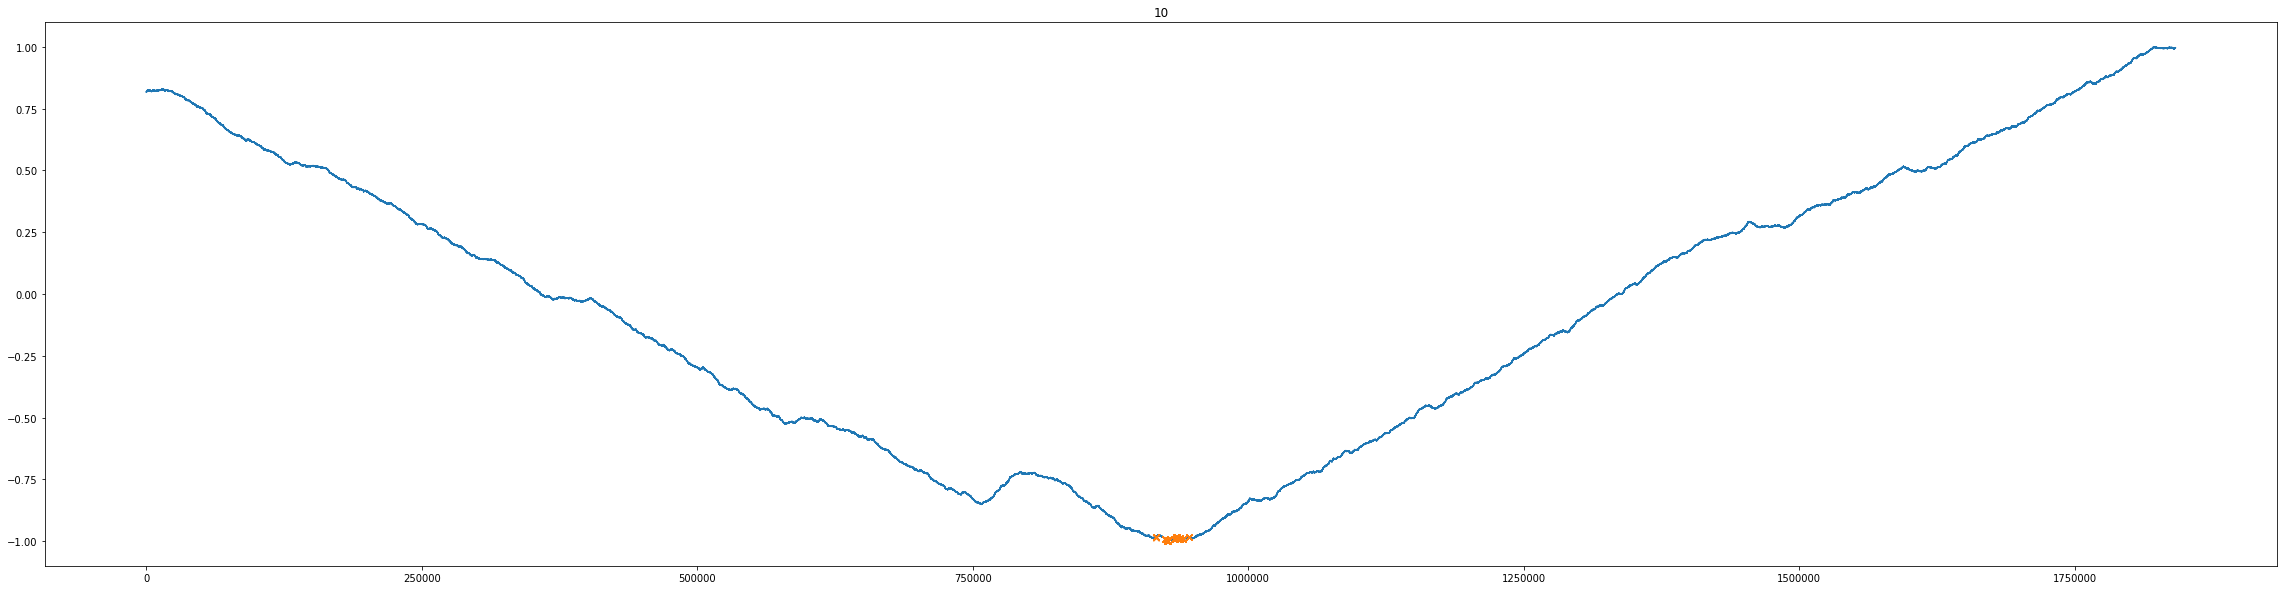

In [12]:
orite.plot_region_list(curve=score_curve, region_list=x[:10], rotated=True)

In [13]:
density_data = []

for region in x:
    
    kdic = region.kmer_info
    
    for k, val in kdic.items():
        
        for kmer_row in val:
            density_data.append(kmer_row[2])

In [14]:
len(density_data)

963

(array([77., 87., 70., 84., 79., 70., 59., 58., 61., 56., 38., 38., 27.,
        29., 14., 20., 16., 10., 10.,  8.,  9.,  6.,  5.,  6.,  2.,  1.,
         3.,  2.,  3.,  1.,  2.,  1.,  1.,  1.,  0.,  3.,  0.,  0.,  0.,
         2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([0.01003344, 0.01179356, 0.01355368, 0.01531379, 0.01707391,
        0.01883402, 0.02059414, 0.02235425, 0.02411437, 0.02587448,
        0.0276346 , 0.02939471, 0.03115483, 0.03291495, 0.03467506,
        0.03643518, 0.03819529, 0.03995541, 0.04171552, 0.04347564,
        0.04523575, 0.04699587, 0.04875598, 0.0505161 , 0.05227621,
        0.05403633, 0.05579645, 0.05755656, 0.05931668, 0.06107679,
        0.06283691, 0.06459702, 0.06635714, 0.06811725, 0.06987737,
        0.07163748, 0.0733976 , 0.07515772, 0.07691783, 0.07867795,
        0.08043806, 0.08219818, 0.08395829, 0.08571841, 0.08747852,
        0.08923864, 0.09099875, 0.09275887, 0.09451898, 0.0962791 ,
        0.09803922]),
 <a list of 50

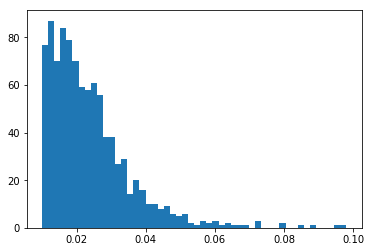

In [15]:
a, b = np.histogram(density_data, bins=50)
plt.hist(density_data, b)

In [16]:
seq = 'ttagctcaaagatcgcgcgaacgaaTGTGTATAActatgcttaaaagcagggtaaaaccagtagATATCCACAtaacaaccttgattctgccgagtgacTGTGCATAAcatgccatttagatcccagcttatacgcaataggatcaccggtcactcacaacaaacgatcctccttaattatatgatcttccaTGTGAATAAtcacTTATCCACAgaggatcatgatcctaataagagatctaataaagagatctttaaataaaaagatcttcttttaattaaaggcgatcctatgccacttggtcgatcgtctaaacttgagtagaatcccccaccccagggcaaacacagaaattcgcataacggcgaggtgcagtacc'
seq = seq.lower()

orite.get_kmers(seq, kmer_length=5, circular=False)


[('agatc', [5, 9, 118, 235, 248, 264]),
 ('aataa', [4, 196, 229, 241, 257]),
 ('gatct', [4, 183, 236, 249, 265]),
 ('gatcc', [4, 119, 165, 223, 286]),
 ('ataac', [4, 30, 72, 104, 359]),
 ('atctt', [3, 184, 250, 266]),
 ('atcct', [3, 166, 224, 287]),
 ('cgatc', [3, 164, 285, 304]),
 ('cataa', [3, 71, 103, 358]),
 ('taaaa', [3, 41, 52, 259]),
 ('ttaaa', [3, 40, 254, 278]),
 ('aaaga', [3, 7, 244, 262]),
 ('cccca', [2, 329, 334]),
 ('acttg', [2, 297, 315]),
 ('ggcga', [2, 283, 364]),
 ('tttaa', [2, 253, 273]),
 ('tcttt', [2, 251, 270]),
 ('taaag', [2, 243, 279]),
 ('ataaa', [2, 242, 258]),
 ('tctaa', [2, 238, 310]),
 ('gagat', [2, 234, 247]),
 ('agaga', [2, 233, 246]),
 ('aagag', [2, 232, 245]),
 ('taata', [2, 228, 240]),
 ('ctaat', [2, 227, 239]),
 ('tccta', [2, 225, 288]),
 ('acaga', [2, 211, 347]),
 ('cacag', [2, 210, 346]),
 ('cactt', [2, 202, 296]),
 ('tcttc', [2, 185, 267]),
 ('tgatc', [2, 182, 222]),
 ('atgat', [2, 181, 221]),
 ('aatta', [2, 175, 276]),
 ('taatt', [2, 174, 275]),
 (